# Magnetic Field and Momentum Dissipation Demo


From our Navier-Stokes equation: 
\begin{equation}
\frac{\partial u}{\partial t} = -\Delta P + \eta \Delta^2 u - \gamma P u
\end{equation}

Where P is pressure, $\eta$ is a viscosity, and u is a fluid velocity, we can apply Chorin's projection method to solve the system numerically. The basic steps of Chorin's method are:

1) Compute intermediate velocity, $u^*$

2) Solve poisson eqn to get P

3) Correct the intermediate velocity to find $u_{(n+1)}$



Reference: 

https://math.berkeley.edu/~chorin/chorin68.pdf

https://www3.nd.edu/~gtryggva/CFD-Course/2011-Lecture-22.pdf

## Magnetic Interaction
The expression for a Magnetic field $\vec B$ acting on a charged particle with charge $q=-e$ moving with velocity $\vec v$ is:

 \begin{align}
\vec F &= q \vec v \times \vec B \\
 &= q ( v_x, v_y, 0) \times (0, 0, B) \\
&= qB (v_x \hat x \times \hat z) + qB( v_y \hat y \times \hat z)\\
 &= qB( -v_x \hat y + v_y \hat x) \\
 &= -eB( v_y, - v_x)\\
 &= B(-v_y, v_x)\\
 \end{align}

Which is a body force that couples the two directions of momentum. We can find the contribution to the $v_x$ and $v_y$ component simply by adding in this coupling term which occurs in the same cell. Working from the equation of motion

$$ \partial_t \vec v = -A \vec v + \nu \nabla^2 \vec v + \frac{qB}{\rho} (\vec v \times \vec B)$$
$$ \partial_t \vec v = - A \vec v + \nu \nabla^2 \vec v + \bar B (-v_y, v_x)$$
where $\bar B = \frac{|e|B}{\rho}$.

In which all other terms, being derivatives with respect to time on the left and space on the right, discretize as usual. The term on the right is simply a coupling $\bar B$ which then couples $v_x$ and $v_y$.

When we discretize the term on the left just to illustrate the scaling with $\Delta t$, where the value of the velocity at a timestep $n$ is given by $\vec v_n$,

$$ \frac{\vec v_{n+1} - \vec v_n}{\Delta t} = - A \vec v_n + \nu \nabla^2 \vec v_n + \bar B (-v_y, v_x)$$

Which then yields

$$ \vec v_{n+1} = \vec v_n - \Delta t \left[ A \vec v_n + \nu \nabla^2 \vec v_n + \bar B (-v_y, v_x)_n \right]$$
Which shows the coupling between the different $v$ components and the magnetic field is scaled by the length of the timestep.

## Dissipative Flow

Dissipation which is dependent on the velocity of a fluid is a familiar component of other differential equations; for instance, if we model the motion of a body through a viscous fluid losing momentum to the medium, we can parameterize the equation of motion with a momentum-dependent term $\gamma$. This would be included in the Navier-stokes equation as a momentum dependent body force

$$ g(\vec p) = -\vec p \gamma$$

To put this in context, sometimes this is captured in the literature (for instance in Levitov & Falkovich arXiv:1508.00836v2, PRL 2016, Equation (1)) as a momentum transport equation:
$$ \partial_t = - \partial_j T_{i,j} - \gamma_p p_i$$

In the code, this function is parameterizable as a simple number, and we can include it in the code accordingly. After dividing by $\rho$ we can write it's integration into the velocity equation (building off of the discretized velocity equation from above), where $\bar{\gamma} = \frac{\gamma}{\rho}$

$$ \vec v_{n+1} = \vec v_n - \Delta t \left[ A \vec v_n + \nu \nabla^2 \vec v_n + \bar B (-v_y, v_x)_n - \bar{\gamma} \vec v_n  \right]$$

Note that we want $\gamma$ to be positive, as this will 'resist' the flow. 




# How to Parameterize $\gamma$ 

$\gamma$ captures momentum-dissipative processes. Since the Feynman moethod may not be accessible to us (stare at the problem, think about it, then write down the full correct answer) We can start off by using the Landau method (take a wild guess and then with the Nobel prize).

The first idea is that $\gamma$, dimensionally, should be a rate. This means that the first naive guess could be, where $\tau_{mr}$ is equal to the momentum relaxation.

$$ \gamma = \frac{1}{\tau_{mr}} = \frac{1}{\tau_{e-ph} } + \frac{1}{\tau_{umklapp}}$$

One idea is that $\gamma$ can depend on the momentum's direction-- for instance, the electron phonon coupling could be much stronger in one direction than in another, or depend on the momentum of the electron-- so $\gamma$ could be parameterized more carefully with greater information about the momentum relaxation. 

One way we could do this is to parameterize $\gamma$ as a matrix in cartesian coordinates; this could also encode scattering channels (in which the electrons bounce from one state to another).

SKETCHES OF IDEAS;

1. $\gamma$ is a vector which has dependence on $q$, $\theta$, $\phi$ in spherical coordinates. The q dependence is an enveloping function that allows for dependence on the momentum of the electrons; thus, momentum-dependent coupling. Additionally, $\theta$ and $\phi$ copmonents can help the scattering processes be non isotropic.
2. $\gamma$ is a sum of sigmoid curves (tanh(x)+1) which are centered at different temperatures to turn on certain scattering processes or mode couplings and parameterize the distribution of electron-phonon interaction strengths.
3. Apply a matrix which changes the cartesian basis to the spherical one, apply a $\gamma$ matrix which applies momentum scattering events which are anisotropic, then transform back into cartesian




In [9]:
# IMPORT STATEMENTS

import numpy as np
from scipy import misc, fftpack
import os
import matplotlib.pyplot as plt
import time

In [75]:
# BOTH OF THESE MAY NEED MODIFYING TO HANDLE BODY FORCES

# ==================================================
# GET INTERMEDIATE VELOCITY (u*) STEP 
# ==================================================
def vel_temps(dt,dx,v,nx,ny,ux,uy,ux_star,uy_star,Bbar=0,gamma=0):
    
    # get ux*
    for i in range(1,nx): 
        for j in range(1,ny+1):
            ux_star[i,j]=ux[i,j] \
                         + dt*(-(0.25/dx)*((ux[i+1,j]+ux[i,j])**2
                         -(ux[i,j]+ux[i-1,j])**2
                         +(ux[i,j+1]+ux[i,j])*(uy[i+1,j]+uy[i,j])
                         -(ux[i,j]+ux[i,j-1])*(uy[i+1,j-1]+uy[i,j-1]))
                         +(v/dx**2)*(ux[i+1,j]+ux[i-1,j]+ux[i,j+1]
                         +ux[i,j-1]-4*ux[i,j])) - dt*Bbar*uy[i,j] -dt*gamma*ux[i,j]
    # get uy*
    for i in range(1,nx+1):
        for j in range(1,ny): 
            uy_star[i,j]=uy[i,j]\
                         +dt*(-(0.25/dx)*((ux[i,j+1]+ux[i,j])*(uy[i+1,j]+uy[i,j])
                         -(ux[i-1,j+1]+ux[i-1,j])*(uy[i,j]+uy[i-1,j])
                         +(uy[i,j+1]+uy[i,j])**2-(uy[i,j]+uy[i,j-1])**2)
                         +(v/dx**2)*(uy[i+1,j]+uy[i-1,j]
                         +uy[i,j+1]+uy[i,j-1]-4*uy[i,j])) +dt*Bbar*ux[i,j] - dt*gamma*uy[i,j]
    return ux_star, uy_star

# ==================================================
# SOLVE POISSON EQUATION TO GET PRESSURE -- borrowed from another code! should likely be replaced
# Somewhat slow at current, I think -- perhaps should find a library function for this? 
# ==================================================
def poisson(dt,dx,nx,ny,b,c,ux_temp,uy_temp,p):

    E = 1; T = 5e-6    # error and tolerance cutoffs
    itmax = 200        # don't let it run too long ... 
    p_prev = np.copy(p)
    for it in range(itmax): 
        for i in range(1,nx+1): 
            for j in range(1,ny+1):
                p[i,j] = b*c[i,j]*( p[i+1,j]+p[i-1,j]+p[i,j+1]+p[i,j-1]
                         -(dx/dt)*(ux_temp[i,j]-ux_temp[i-1,j]+uy_temp[i,j]-uy_temp[i,j-1]))\
                         +(1-b)*p[i,j]
        E = np.max( abs( p - p_prev ) ) 
        p_prev = p
        if E < T:  
            break 
    print("Chorin took ",it," iterations")
    return p


# Advection-DIffusion 
The discrete time-evolution step is as follows:

$$ v_x^* = v^x_{i,j}+ \Delta t \left[ -\frac{1}{4 \Delta x} \left( (v^x_{i+1,j} + v^x_{i,j})^2 - (v^x_{i,j} + v^x_{i-1,j})^2 + (v^x_{i,j+1} + v^x_{i,j})(v^y_{i+1,j} + v^y_{i,j}) - (v^x_{i,j} + v^x_{i,j-1})(v^y_{i+1,j-1} +v^y_{i,j-1}  \right) \right) + \Delta t \frac{\nu}{\Delta x^2}  \left(v^x_{i+1,j} + v^x_{i-1,j} + v^x_{i,j+1} + v^x_{i,j-1} - 4 v^x_{i,j} ) \right]$$ 


$$ v_y^* = v^y_{i,j}+ \Delta t \left[ -\frac{1}{4 \Delta x} \left( (v^y_{i,j+1} + v^y_{i,j})^2   - (v^y_{i,j} + v^y_{i,j-1})^2 +  (v^x_{i,j+1} + v^x_{i,j})(v^y_{i+1,j} + v^y_{i,j}) - (v^x_{i-1,j+1} + v^x_{i-1,j} )( v^y_{i,j} + v^y_{i-1,j}) \right)  + \Delta t  \frac{\nu}{(\Delta x)^2} \left( v^y_{i+1,j} + v^y_{i-1,j} + v^y_{i,j+1} + v^y_{i,j-1} - 4 v^y_{i,j} \right) \right]
$$

The first term (prefactored by $ \frac{\Delta t}{4 \Delta x}$) is identified with the advective flow/the material derivative.

The second term (prefactored by $\frac{\Delta t \nu}{(\Delta x)^2}$) is identified with the viscous flow and 'conduction' of x- and y-velocity across neighboring cells.

# Incompressible Flow
Chorin's method works as follows.

In the absence of body forces, we split the advection-diffusion timestep below:
$$ \frac{u^{n+1}_{i,j} - u^n_{i,j}}{\Delta t} = - A_{i,j}^n - \nabla P_{i,j} + D^n_{i,j}$$

Into two intermediate steps. First, we find an intermediate velocity from the typical operation of the A-D processess in the absence of pressure forces:

$$ u_{i,j}^* = u_{i,j}^n + \Delta t( - A^n_{i,j} + D^n_{i,j})$$
Which subs into the above equation as 
$$ \frac{u^{n+1}_{i,j} = u^*_{i,j} - \Delta t \nabla P_{i,j}$$

Then, by assuming mass conservation ($\nabla \cdot u^{n+1} =0$), we arrive at the equation

$$ \nabla^2 P_{i,j} = \frac{1}{\Delta t} \nabla \cdot u^t){i,j}$$

If this equation is satisfied, then we have an appropriate pressure field which satisfies the incompressibility condition. After solving for the pressure field, we compute the equation above ( $\frac{u^{n+1}_{i,j} = u^*_{i,j} - \Delta t \nabla P_{i,j}$) to find the new time step.

When computing this on a lattice, we run an iterative procedure in which we seek to satisfy the equation (for an interior point on the domain):

$$ \beta \frac{1}{4} \left( P_{i+1,j} + P_{i-1,j} + P_{i,j+1} + P_{i,j-1} \right) 



('Chorin took ', 0, ' iterations')


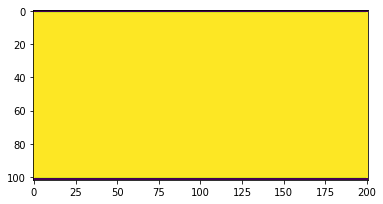

Time:  0.00125
('Chorin took ', 0, ' iterations')


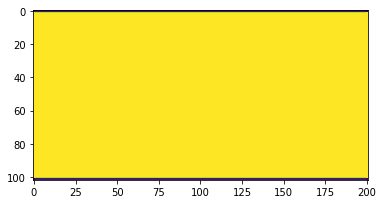

Time:  0.0025
('Chorin took ', 0, ' iterations')


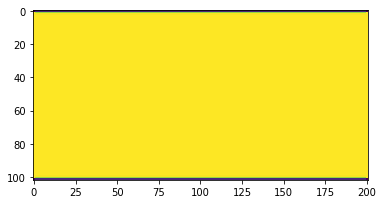

Time:  0.00375
('Chorin took ', 0, ' iterations')


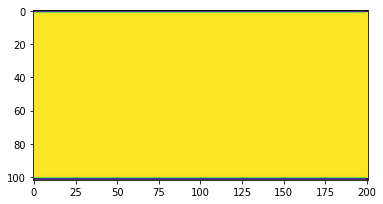

Time:  0.005
('Chorin took ', 0, ' iterations')


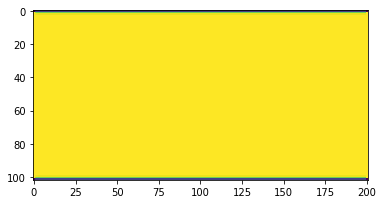

Time:  0.00625
('Chorin took ', 0, ' iterations')


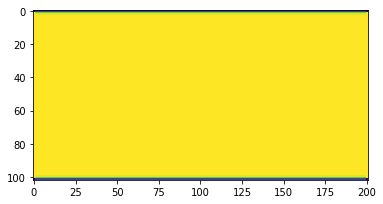

Time:  0.0075
('Chorin took ', 0, ' iterations')


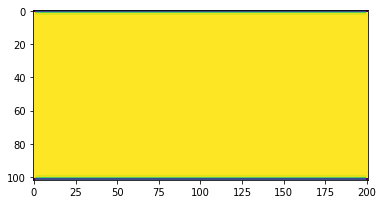

Time:  0.00875
('Chorin took ', 0, ' iterations')


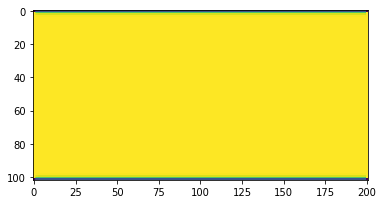

Time:  0.01
('Chorin took ', 0, ' iterations')


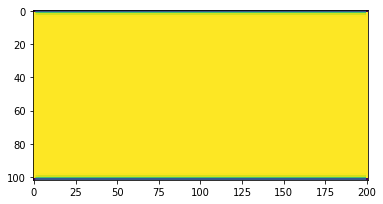

Time:  0.01125
('Chorin took ', 0, ' iterations')


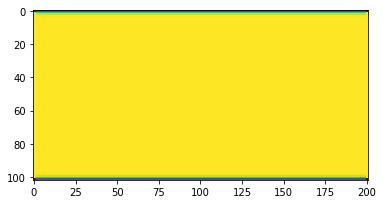

Time:  0.0125
6.10417509079


In [78]:
def projection(Bbar=0,Ebar=0):
    
    # GRID PARAMETERS ===========================================================
    lx = 1.0                      # x length dimension
    ly = 2.0                      # y length dimension
    gridres = 100
    nx = int(gridres*lx)          # x grid resolution
    ny = int(gridres*ly)          # y grid resolution  
    dx = lx/nx         

    X,Y = np.meshgrid(np.linspace(0,lx,nx),np.linspace(0,ly,ny))
    
    
    # SIMULATION PARAMETERS =====================================================
    mu = 5.           # dynamic viscosity (kg / m*s)
    rho = 1000.       # Fluid density (kg/m^3) 
    v=mu/rho          # kinematic viscosity
    b=1.25            # relaxation? 

    # INITIALIZE ARRAYS =========================================================
    ux=np.zeros((nx+1,ny+2))        # x vel
    uy=np.zeros((nx+2,ny+1))        # y vel
    p=np.zeros((nx+2,ny+2))         # pressure 
    ux_star=np.zeros((nx+1,ny+2))   # u*
    uy_star=np.zeros((nx+2,ny+1))   # v*


    # part of my borrowed poisson solving .... again, maybe replce this with a library function? 
    c=1/4*np.ones((nx+2,ny+2))  # interior
    c[1,2:ny]=1/3             # boundary 
    c[nx,2:ny]=1/3            # boundary 
    c[2:nx,1]=1/3             # boundary 
    c[2:nx,ny]=1/3            # boundary 
    c[1,1]=1/2                  # corner
    c[1,ny]=1/2                 # corner 
    c[nx,1]=1/2                 # corner 
    c[nx,ny]=1/2                # corner 

    # BOUNDARY CONDTIONS 
    U = 1                # reference velocity 
    xnorth = 0.0             # injects with some reference velocity at the beginning of every time step
    xsouth = 0.0          
    yright = 0.0
    yleft = 0.0
    uy = U*np.ones((nx+2,ny+1))  # y vel initialized to a constant --- obviously can be changed and played with
    #uy = U*np.zeros((nx+2,ny+1))  # y vel initialized to a constant --- obviously can be changed and played with

    nsteps = 10
    dt = 0.00125               # perhaps better to calculate this somehow, rather than make a guess? 
    
    # Print info
    print_num = 5      # print every this many steps

    # TIME STEPPING ================================================
    for j in range(1,nsteps+1):
        
        t = j*dt
        
        # these are some BCs -- totally should be changed and updated 
        # boundary conditions ---> currently, this is borrowed from another code... 
        # someone should try to implement PBCs 
        
        #ux[0:nx+1,:] = (ux[0:nx+1,:] + xnorth )* np.tanh(2.5*t)    # for example, I've played with this to show fluid being 
                                                               # injected from the top --- would be better to have it 
                                                               # stream around the side 
        #ux[0:nx+1,0]   = ( 2*xnorth-ux[0:nx+1,1]  )  * np.tanh(2.5*t)
        #ux[0:nx+1,ny+1] = ( 2*xsouth-ux[0:nx+1,ny] )  * np.tanh(2.5*t)
        #uy[0,0:ny+1]   = ( 2*yleft-uy[1,0:ny+1] )  * np.tanh(2.5*t)
        #uy[nx+1,0:ny+1]= ( 2*yright-uy[nx,0:ny+1] )* np.tanh(2.5*t)
        #
        # Trying some new BC slices; will let you know how it goes...
        #
        ux[:,0]   = ( 2*xnorth-ux[0:nx+1,1]  )  #* np.tanh(2.5*t)
        ux[:,ny+1] = ( 2*xsouth-ux[0:nx+1,ny] ) # * np.tanh(2.5*t)
        uy[0,:]   = ( 2*yleft-uy[1,0:ny+1] ) # * np.tanh(2.5*t)
        uy[nx+1,:]= ( 2*yright-uy[nx,0:ny+1] )#* np.tanh(2.5*t)

        for k in range(0,1):

            # calculate temporary velocity fields 
            ux_star, uy_star = vel_temps(dt,dx,v,nx,ny,ux,uy,ux_star,uy_star,Bbar)

            # solve Poisson eqn for pressure? 
            p = poisson(dt,dx,nx,ny,b,c,ux_star,uy_star,p)

            # repair velocity 
            ux[1:nx,1:ny+1] = ux_star[1:nx,1:ny+1] - (dt/dx) * ( p[2:nx+1,1:ny+1] - p[1:nx,1:ny+1] )
            uy[1:nx+1,1:ny] = uy_star[1:nx+1,1:ny] - (dt/dx) * ( p[1:nx+1,2:ny+1] - p[1:nx+1,1:ny] )
        
        # Check how the simulation is going 
        if ( j % print_num == 0):
            
            # save images to make the video
            plt.imshow(uy)
            #xindexsample=[x*11 for x in range(10)]; xindexsample[-1]=99
            #yindexsample=[x*11 for x in range(19)]; yindexsample[-1]=199
            #velsquared= np.sqrt(np.square(ux[:,:-1]) + np.square(uy[:-1,:]))
            #plt.imshow(velsquared,cmap=plt.get_cmap('winter'))     #

            #for n in xindexsample:
            #    for m in yindexsample:
            #        plt.quiver(X[m,n]*100,Y[m,n]*200,ux[n,m],uy[n,m])

                    #plt.quiver(X[n,m],Y[n,m],ux[:,:-1],uy[:-1,:])
            #plt.savefig('./' + "/file%03d.png" % j)    # uncomment this if you will try to make a movie afterwards
            plt.show()
            print 'Time: ', t

            
start = time.time()

projection(0,0)


end = time.time()
print(end - start)

In [68]:
# RUN THE CODE HERE
# the general method is good I think -- needs to have some modification to match our needs 
# in terms of forces, geometry, BCs.... etc. 


In [19]:
# DOES NOT WORK WELL PRESENTLY -- fix if you can!
# It should be reading in the images output by the main code, and then formatting them into a video
# if remove section at the bottom is uncommented, it will also clean up all the left over image files

# This requires ffmpeg, which can be installed by following the instructions here: 
# http://www.renevolution.com/ffmpeg/2013/03/16/how-to-install-ffmpeg-on-mac-os-x.html

import glob
import os
import subprocess

def generate_video():

    subprocess.call([
        'ffmpeg', '-framerate', '30', '-i', 'file%03d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'vid.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

generate_video()